In [1]:
# Importing necessary libraries
!pip install langid
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml.feature import Tokenizer, StopWordsRemover, Word2Vec, PCA
from pyspark.ml.clustering import KMeans
from pyspark.sql.functions import col, lower, regexp_replace, split, udf
from pyspark.sql.types import StringType, IntegerType 
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf
import numpy as np
import langid
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from pyspark.ml.linalg import DenseVector, SparseVector
from pyspark.sql.functions import col, udf

In [2]:
# Create Spark session
spark = SparkSession.builder \
    .config("spark.sql.shuffle.partitions", 10) \
    .config("spark.executor.memory", "8g") \
    .config("spark.driver.memory", "8g") \
    .config("spark.driver.maxResultSize", "8g") \
    .config("spark.executor.heartbeatInterval", "100000s") \
    .config("spark.network.timeout", "10000000s") \
    .master("local[*]") \
    .appName("Project 3") \
    .getOrCreate()

# Read data
# df = spark.read.json("./dblp-ref/*.json", multiLine=True)
df=spark.read.json("./dblp-ref/dblp-ref-0.json")
# df = spark.read.json(["./dblp-ref/dblp-ref-0.json", "./dblp-ref/dblp-ref-1.json", "./dblp-ref/dblp-ref-2.json", "./dblp-ref/dblp-ref-3.json"], multiLine=True)

In [3]:
# df = df.limit(50)


In [4]:
# Show the schema
df.printSchema()
total_records = df.count()
print("Total number of records:", total_records)

df.show(5)
# print(f"Number of records: {df.count()}")

root
 |-- abstract: string (nullable = true)
 |-- authors: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- id: string (nullable = true)
 |-- n_citation: long (nullable = true)
 |-- references: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- title: string (nullable = true)
 |-- venue: string (nullable = true)
 |-- year: long (nullable = true)

Total number of records: 1000000
+--------------------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+----+
|            abstract|             authors|                  id|n_citation|          references|               title|               venue|year|
+--------------------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+----+
|The purpose of th...|[Makoto Satoh, Ry...|00127ee2-cb05-48c...|         0|[51c7e02e-f5ed-43...|Preliminary Desig...|international c

In [5]:
# Display summary statistics
df.describe().show()

# Check for missing values (excluding `isnan`)
df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns]).show()

# Distribution of citations
df.select("n_citation").describe().show()

# Check for null abstracts and titles
df.filter(df.abstract.isNull() | df.title.isNull()).show()

+-------+--------------------+--------------------+------------------+-------------------------------------+--------------------+----------------+
|summary|            abstract|                  id|        n_citation|                                title|               venue|            year|
+-------+--------------------+--------------------+------------------+-------------------------------------+--------------------+----------------+
|  count|              753646|             1000000|           1000000|                              1000000|             1000000|         1000000|
|   mean|                NULL|                NULL|          30.87573|                                 NULL|                NULL|     2006.365124|
| stddev|                NULL|                NULL|137.94247310778852|                                 NULL|                NULL|7.83383289543257|
|    min| ...|000000b8-7f59-49a...|                 0|                 ! and ? – Storage...|          

In [6]:
# Filter only English documents
def detect_language(text):
    if text is None:
        return None
    lang, _ = langid.classify(text)
    return lang

# Registering UDF
lang_detect_udf = udf(detect_language, StringType())

# Add a new column for language detection
df = df.withColumn("language", lang_detect_udf(df.abstract))

# Filter only English documents
df = df.filter(df.language == 'en')
df.show()

+--------------------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+----+--------+
|            abstract|             authors|                  id|n_citation|          references|               title|               venue|year|language|
+--------------------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+----+--------+
|The purpose of th...|[Makoto Satoh, Ry...|00127ee2-cb05-48c...|         0|[51c7e02e-f5ed-43...|Preliminary Desig...|international con...|2013|      en|
|This paper descri...|[Gareth Beale, Gr...|001c58d3-26ad-46b...|        50|[10482dd3-4642-41...|A methodology for...|visual analytics ...|2011|      en|
|This article appl...|[Altaf Hossain, F...|001c8744-73c4-4b0...|        50|[2d84c0f2-e656-4c...|Comparison of GAR...|pattern recogniti...|2009|      en|
|Recent achievemen...|[Ankita Brahmacha...|00a119c4-d367-460...|         0|[84d471

In [7]:
# Lowercase and remove punctuation
df_cleaned = df.withColumn("cleaned_abstract", lower(col("abstract")))
df_cleaned = df_cleaned.withColumn("cleaned_abstract", regexp_replace(col("cleaned_abstract"), r'[!()\-\[\]{};:\'",<>./?@#$%^&*_~]', ''))

In [8]:
# Tokenize the text
tokenizer = Tokenizer(inputCol="cleaned_abstract", outputCol="words")
df_tokenized = tokenizer.transform(df_cleaned)

In [9]:
# Remove stop words
custom_stop_words = ['doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 'al.', 'Elsevier', 'PMC', 'CZI', 'www']
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words", stopWords=StopWordsRemover().getStopWords() + custom_stop_words)
df_filtered = remover.transform(df_tokenized)

In [10]:
print(df_filtered.count())

749521


In [11]:
# Train a Word2Vec model
word2vec = Word2Vec(vectorSize=10, minCount=1, inputCol="filtered_words", outputCol="word2vec_features")
model = word2vec.fit(df_filtered)
df_vectorized = model.transform(df_filtered)

In [12]:
# Select only the columns we need
df_vectorized = df_vectorized.select("id", "title", "word2vec_features")

In [13]:
# # Define UDF for converting sparse to dense vectors
# def to_dense(v):
#     if isinstance(v, SparseVector):
#         return DenseVector(v.toArray())
#     elif isinstance(v, DenseVector):
#         return v
#     else:
#         raise TypeError("Unsupported vector type")

# to_dense_udf = udf(to_dense, VectorUDT())

# # Apply UDF to convert features to dense vectors
# df_dense = df_vectorized.withColumn('dense_features', to_dense_udf(col('word2vec_features')))

# # Select only the columns we need
# df_dense = df_dense.select("id", "title", "dense_features")
# df_dense.show()


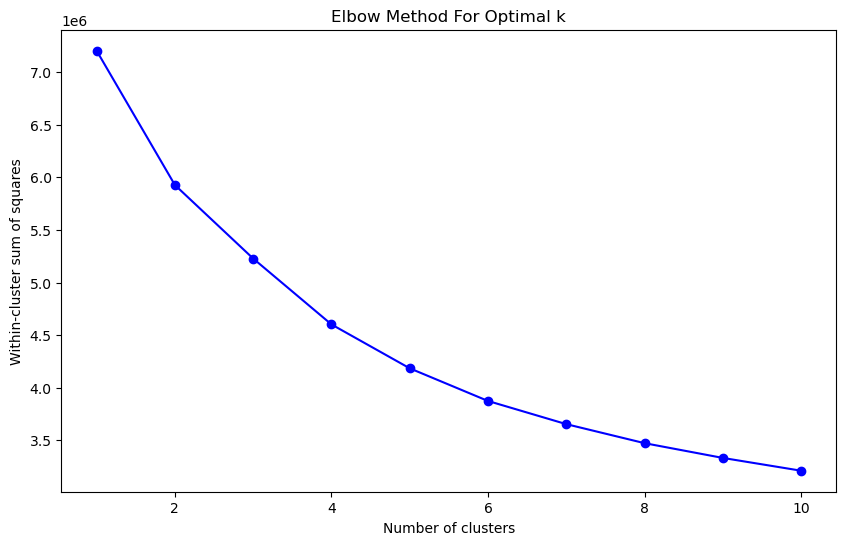

                                     id  \
0  00127ee2-cb05-48ce-bc49-9de556b93346   
1  001c58d3-26ad-46b3-ab3a-c1e557d16821   
2  001c8744-73c4-4b04-9364-22d31a10dbf1   
3  00a119c4-d367-4607-b3c8-b237f2971bff   
4  00bcf2d5-1592-46b0-81fd-933f90b5ecca   

                                               title  \
0  Preliminary Design of a Network Protocol Learn...   
1  A methodology for the physically accurate visu...   
2  Comparison of GARCH, Neural Network and Suppor...   
3  Identifying Psychological Theme Words from Emo...   
4  Multisymplectic Spectral Methods for the Gross...   

                                      dense_features  Cluster  
0  [-0.14051668350962368, 0.20132064852058082, -0...        2  
1  [-0.008675841195089323, 0.024602464068815246, ...        2  
2  [0.1949866042407446, 0.24936372446719296, -0.3...        0  
3  [-0.11769064955255935, 0.01888068303019858, -0...        2  
4  [0.3042276172261489, 0.1575311414015136, -0.09...        1  


In [14]:
from pyspark.sql.functions import col, udf
from pyspark.ml.linalg import DenseVector, SparseVector, VectorUDT
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Define UDF for converting sparse to dense vectors
def to_dense(v):
    if isinstance(v, SparseVector):
        return DenseVector(v.toArray())
    elif isinstance(v, DenseVector):
        return v
    else:
        raise TypeError("Unsupported vector type")

to_dense_udf = udf(to_dense, VectorUDT())

# Apply UDF to convert features to dense vectors
df_dense = df_vectorized.withColumn('dense_features', to_dense_udf(col('word2vec_features')))

# Select only the columns we need
df_dense = df_dense.select("id", "title", "dense_features")

# Convert the Spark DataFrame to Pandas DataFrame
df_dense_pd = df_dense.toPandas()

# Extract the dense features column as a NumPy array
features = np.array(df_dense_pd['dense_features'].tolist())

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(features)

# Apply PCA to reduce dimensions while keeping 95% of the variance
pca = PCA(n_components=0.95)
reduced_data = pca.fit_transform(scaled_data)

# Determine the optimal number of clusters using the elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(reduced_data)
    wcss.append(kmeans.inertia_)

# Plotting the elbow method
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, 'bo-')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Within-cluster sum of squares')
plt.show()

# Apply K-means with the optimal number of clusters (assuming k = 3)
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(reduced_data)

# Adding the cluster labels to the original DataFrame
df_dense_pd['Cluster'] = clusters

# Show some rows of the DataFrame with cluster labels
print(df_dense_pd.head())


In [15]:
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA

# scaler = StandardScaler()
# scaled_data = scaler.fit_transform(df_dense)

# pca = PCA(n_components=0.95)
# reduced_data = pca.fit_transform(scaled_data)

# # Plotting the elbow method
# plt.figure(figsize=(10, 6))
# plt.plot(range(1, 11, wcss, 'bo-'))
# plt.title('Elbow Method For Optimal k')
# plt.xlabel('Number of clusters')
# plt.ylabel('Within-cluster sum of squares')
# plt.show()

# # Step 4: Apply K-means with the optimal number of clusters
# # Assuming from the elbow method, we find k = 3
# optimal_k = 3
# kmeans = KMeans(n_clusters=optimal_k, random_state=42)
# clusters = kmeans.fit_predict(reduced_data)

# # Adding the cluster labels to the original DataFrame
# df_sampled['Cluster'] = clusters

# # Show some rows of the DataFrame with cluster labels
# df_sampled.show(5)

In [16]:
# # Use PCA to reduce dimensions
# pca = PCA(k=2, inputCol="word2vec_features", outputCol="pca_features")
# # df_sampled_repartitioned = df_sampled.repartition(100)
# # df_sampled_repartitioned.persist()
# pca_model = pca.fit(pca)
# df_pca = pca_model.transform(df_sampled_repartitioned)
# df_pca.show()

pca = PCA(k=2, inputCol="word2vec_features", outputCol="pca_features")
pca_model = pca.fit(df_sampled)
df_pca = pca_model.transform(df_sampled)
df_pca.show()

TypeError: PCA.__init__() got an unexpected keyword argument 'k'

In [ ]:
# # Elbow Method to Find Optimal K
# costs = []
# for k in range(2, 21):
#     kmeans = KMeans(k=k, seed=1, featuresCol="pca_features")
#     model = kmeans.fit(df_pca)
#     costs.append(model.summary.trainingCost)

# plt.plot(range(2, 21), costs, marker='o')
# plt.xlabel('Number of Clusters (k)')
# plt.ylabel('Cost')
# plt.title('Elbow Method for Optimal k')
# plt.show()

In [ ]:
# KMeans Clustering (using the optimal k from the elbow method)
optimal_k = 10  # Set this to the optimal value from the elbow method
kmeans = KMeans(k=optimal_k, seed=1, featuresCol="pca_features")
model = kmeans.fit(df_pca)
df_clustered = model.transform(df_pca)
df_clustered.show()

In [ ]:
# from pyspark.ml.clustering import BisectingKMeans

# # Apply Bisecting K-means clustering
# bisecting_kmeans = BisectingKMeans(k=100, seed=1, featuresCol="pca_features")
# model = bisecting_kmeans.fit(df_pca)
# df_clustered = model.transform(df_pca)
# df_clustered.show()


In [ ]:
# from pyspark.ml.clustering import GaussianMixture

# # Apply Gaussian Mixture Model clustering
# gmm = GaussianMixture(k=20, seed=1, featuresCol="pca_features")
# model = gmm.fit(df_pca)
# df_clustered = model.transform(df_pca)
# df_clustered.show()


In [ ]:
# from pyspark.ml.clustering import KMeans

# # Apply K-means clustering with 20 clusters
# kmeans = KMeans(k=100, seed=1, featuresCol="pca_features")
# model = kmeans.fit(df_pca)
# df_clustered = model.transform(df_pca)
# df_clustered.show()


In [ ]:
# import matplotlib.pyplot as plt
# from pyspark.ml.clustering import BisectingKMeans

# # Elbow Method to Find Optimal K for Bisecting K-means
# costs = []
# k_values = range(2, 41)  # Trying K values from 2 to 100

# for k in k_values:
#     bisecting_kmeans = BisectingKMeans(k=k, seed=1, featuresCol="pca_features")
#     model = bisecting_kmeans.fit(df_pca)
#     costs.append(model.computeCost(df_pca))

# # Plot the costs against K values
# plt.plot(k_values, costs, marker='o')
# plt.xlabel('Number of Clusters (k)')
# plt.ylabel('Cost')
# plt.title('Elbow Method for Optimal k using Bisecting K-means')
# plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Elbow Method to Find Optimal K
costs = []
for k in range(2, 41):
    kmeans = KMeans(k=k, seed=1, featuresCol="pca_features")
    model = kmeans.fit(df_pca)
    costs.append(model.summary.trainingCost)

plt.plot(range(2, 41), costs, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Cost')
plt.title('Elbow Method for Optimal k')
plt.show()


In [ ]:
# Basic search engine function
def recommend_papers(title, top_n=5):
    paper_cluster = df_clustered.filter(df_clustered.title == title).select("prediction").collect()[0][0]
    cluster_papers = df_clustered.filter(df_clustered.prediction == paper_cluster)
    paper_features = np.array(cluster_papers.filter(cluster_papers.title == title).select("pca_features").collect()[0][0])
    similarities = []

    for row in cluster_papers.collect():
        other_title = row["title"]
        other_features = np.array(row["pca_features"])
        similarity = cosine_similarity([paper_features], [other_features])[0][0]
        similarities.append((other_title, similarity))

    similarities.sort(key=lambda x: x[1], reverse=True)
    return similarities[:top_n]

# Example usage
recommended_papers = recommend_papers("example_paper_title", top_n=2)
print(recommended_papers)

In [ ]:
# Importing necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml.feature import Tokenizer, StopWordsRemover, Word2Vec, PCA
from pyspark.ml.clustering import KMeans
from pyspark.sql.functions import col, lower, regexp_replace, udf
from pyspark.sql.types import StringType
from pyspark.ml.linalg import SparseVector, DenseVector, VectorUDT
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Create Spark session
spark = SparkSession.builder \
    .config("spark.sql.shuffle.partitions", 10) \
    .config("spark.executor.memory", "8g") \
    .config("spark.driver.memory", "8g") \
    .config("spark.driver.maxResultSize", "8g") \
    .master("local[*]") \
    .appName("Project 3") \
    .getOrCreate()

# Read data
df = spark.read.json("./dblp-ref/*.json", multiLine=True)

# Show the schema
df.printSchema()
df.show(5)
print(f"Number of records: {df.count()}")

# Check for missing values
df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns]).show()

# Filter only English documents
# df = df.filter(df.language == 'en')

# Lowercase and remove punctuation
df_cleaned = df.withColumn("cleaned_abstract", lower(col("abstract")))
df_cleaned = df_cleaned.withColumn("cleaned_abstract", regexp_replace(col("cleaned_abstract"), r'[!()\-\[\]{};:\'",<>./?@#$%^&*_~]', ''))

# Tokenize the text
tokenizer = Tokenizer(inputCol="cleaned_abstract", outputCol="words")
df_tokenized = tokenizer.transform(df_cleaned)

# Remove stop words
custom_stop_words = ['doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 'al.', 'Elsevier', 'PMC', 'CZI', 'www']
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words", stopWords=StopWordsRemover().getStopWords() + custom_stop_words)
df_filtered = remover.transform(df_tokenized)

# Train a Word2Vec model
word2vec = Word2Vec(vectorSize=100, minCount=1, inputCol="filtered_words", outputCol="word2vec_features")
model = word2vec.fit(df_filtered)
df_vectorized = model.transform(df_filtered)

# Define UDF for converting sparse to dense vectors
def to_dense(v):
    if isinstance(v, SparseVector):
        return DenseVector(v.toArray())
    elif isinstance(v, DenseVector):
        return v
    else:
        raise TypeError("Unsupported vector type")

to_dense_udf = udf(to_dense, VectorUDT())

# Apply UDF to convert features to dense vectors
df_dense = df_vectorized.withColumn('dense_features', to_dense_udf(col('word2vec_features')))

# Select only the columns we need
df_dense = df_dense.select("id", "title", "dense_features")

# Sample the data
def sample_data(df, fraction, max_attempts=5):
    attempt = 0
    sampled_df = df.sample(fraction=fraction, seed=42)
    while sampled_df.count() == 0 and attempt < max_attempts:
        fraction *= 2  # Increase fraction to get more data
        sampled_df = df.sample(fraction=fraction, seed=42)
        attempt += 1
    if sampled_df.count() == 0:
        raise ValueError("Sampled DataFrame is empty after several attempts.")
    return sampled_df

df_sampled = sample_data(df_dense, 0.1)
print(f"Sampled DataFrame count: {df_sampled.count()}")
df_sampled.show(5)

# Use PCA to reduce dimensions
pca = PCA(k=2, inputCol="dense_features", outputCol="pca_features")
df_sampled_repartitioned = df_sampled.repartition(100)
df_sampled_repartitioned.persist()
pca_model = pca.fit(df_sampled_repartitioned)
df_pca = pca_model.transform(df_sampled_repartitioned)
df_pca.show()

# Elbow Method to Find Optimal K
costs = []
for k in range(2, 21):
    kmeans = KMeans(k=k, seed=1, featuresCol="pca_features")
    model = kmeans.fit(df_pca)
    costs.append(model.summary.trainingCost)

plt.plot(range(2, 21), costs, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Cost')
plt.title('Elbow Method for Optimal k')
plt.show()

# KMeans Clustering (using the optimal k from the elbow method)
optimal_k = 10  # Set this to the optimal value from the elbow method
kmeans = KMeans(k=optimal_k, seed=1, featuresCol="pca_features")
model = kmeans.fit(df_pca)
df_clustered = model.transform(df_pca)

# Basic search engine function
def recommend_papers(title, top_n=5):
    paper_cluster = df_clustered.filter(df_clustered.title == title).select("prediction").collect()[0][0]
    cluster_papers = df_clustered.filter(df_clustered.prediction == paper_cluster)
    paper_features = np.array(cluster_papers.filter(cluster_papers.title == title).select("pca_features").collect()[0][0])
    similarities = []

    for row in cluster_papers.collect():
        other_title = row["title"]
        other_features = np.array(row["pca_features"])
        similarity = cosine_similarity([paper_features], [other_features])[0][0]
        similarities.append((other_title, similarity))

    similarities.sort(key=lambda x: x[1], reverse=True)
    return similarities[:top_n]

# Example usage
recommended_papers = recommend_papers("example_paper_title", top_n=5)
print(recommended_papers)
